<a href="https://colab.research.google.com/github/MarynaMarkova/TensorFlow_Coursera/blob/main/443_Sunspots_CNN_RNN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Sunspots with Neural Networks

# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

# Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
#    plt.show()

# Download and Preview the Dataset

In [3]:
# Download the Dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2023-07-26 14:45:47--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.128, 142.251.162.128, 74.125.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2023-07-26 14:45:47 (58.7 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



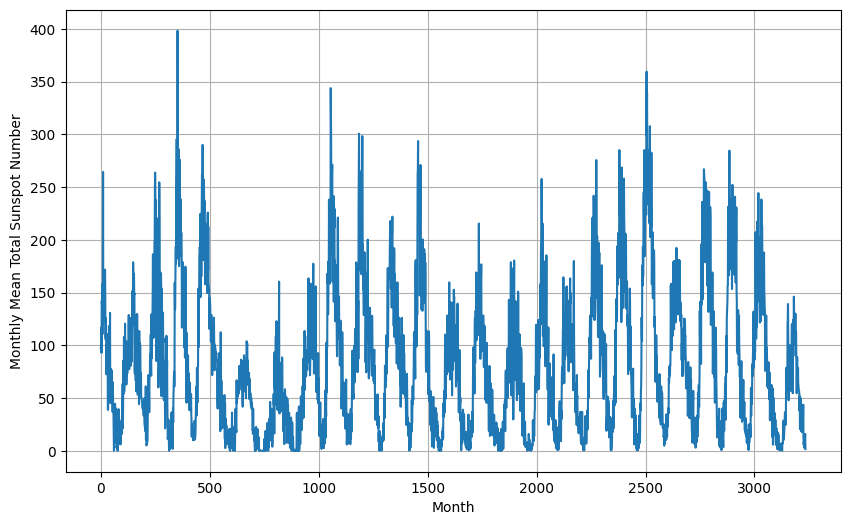

In [4]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

## Split the Dataset


In [5]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

# Prepare Features and Labels

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [7]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Build the Model

In [8]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

# Tune the Learning Rate

In [9]:
# Get initial weights
init_weights = model.get_weights()

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 17s 19ms/step - loss: 84.4370 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 1s 9ms/step - loss: 66.5873 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 1s 12ms/step - loss: 52.6827 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 2s 14ms/step - loss: 46.1530 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 2s 19ms/step - loss: 42.6533 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 1s 9ms/step - loss: 39.9520 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 1s 12ms/step - loss: 37.6942 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 1s 10ms/step - loss: 35.8621 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 1s 9ms/step - loss: 34.2680 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 1s 11ms/step - loss: 32.9165 - lr: 2.8184e-08
Epoch 11/10

(1e-08, 0.001, 0.0, 100.0)

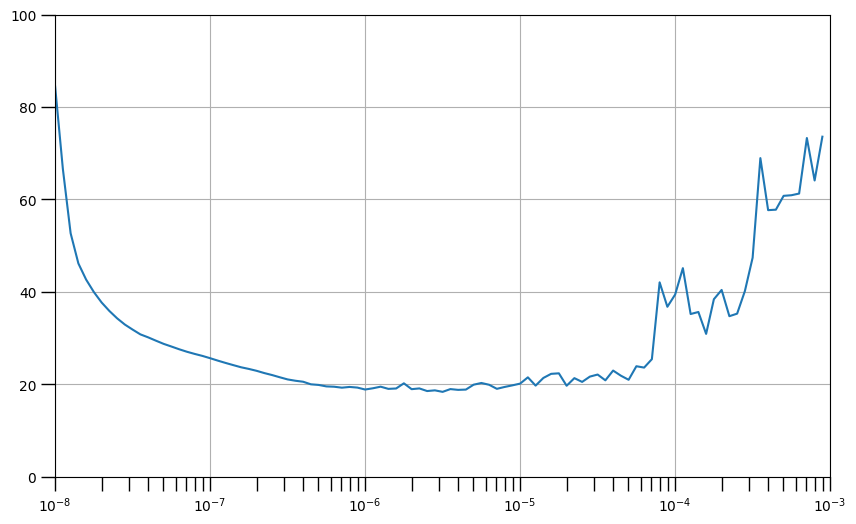

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

# Train the Model

In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [13]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [14]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 4s 11ms/step - loss: 37.1440 - mae: 37.6403
Epoch 2/100
93/93 [==============================] - 1s 10ms/step - loss: 24.9453 - mae: 25.4388
Epoch 3/100
93/93 [==============================] - 2s 15ms/step - loss: 22.8905 - mae: 23.3843
Epoch 4/100
93/93 [==============================] - 1s 14ms/step - loss: 21.7236 - mae: 22.2171
Epoch 5/100
93/93 [==============================] - 1s 10ms/step - loss: 20.9558 - mae: 21.4483
Epoch 6/100
93/93 [==============================] - 1s 10ms/step - loss: 20.6249 - mae: 21.1175
Epoch 7/100
93/93 [==============================] - 1s 10ms/step - loss: 20.4405 - mae: 20.9329
Epoch 8/100
93/93 [==============================] - 1s 10ms/step - loss: 20.7008 - mae: 21.1947
Epoch 9/100
93/93 [==============================] - 1s 10ms/step - loss: 19.5534 - mae: 20.0465
Epoch 10/100
93/93 [==============================] - 1s 9ms/step - loss: 19.2136 - mae: 19.7060
Epoch 11/100
93/93 [==========

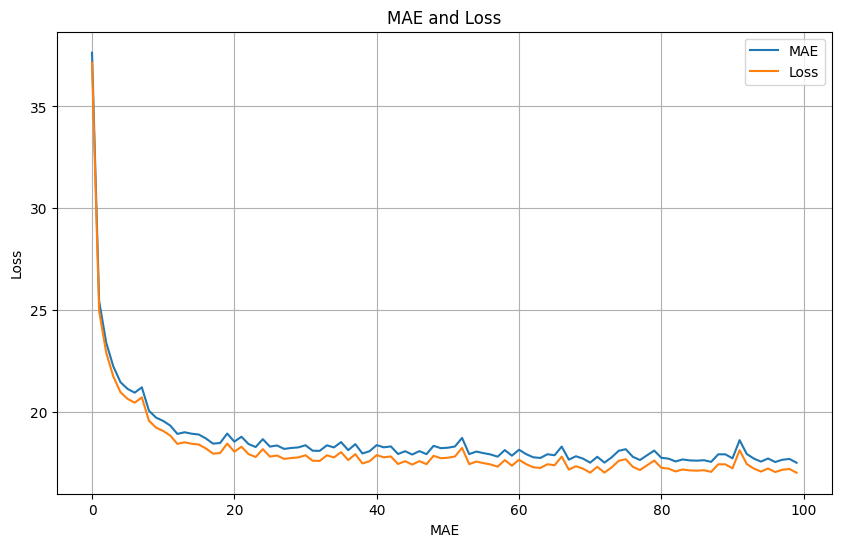

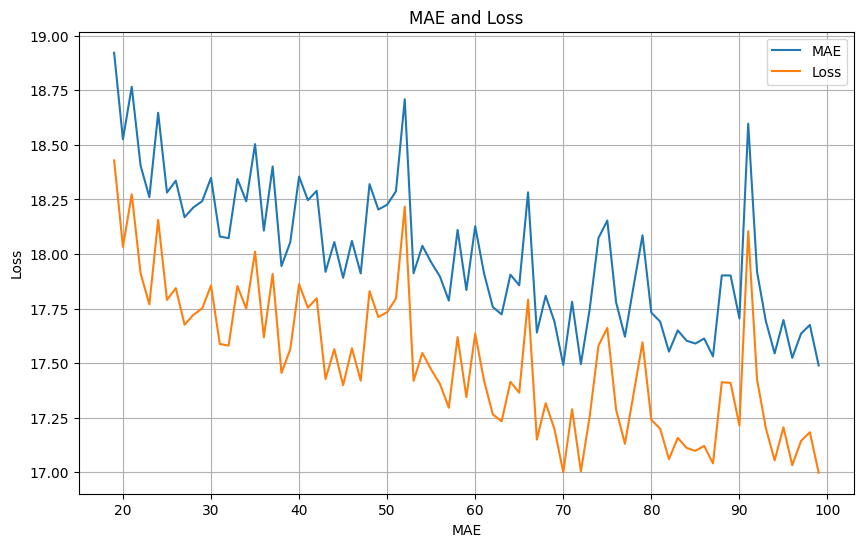

In [15]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Model Prediction

In [16]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

8/8 [==============================] - 1s 12ms/step


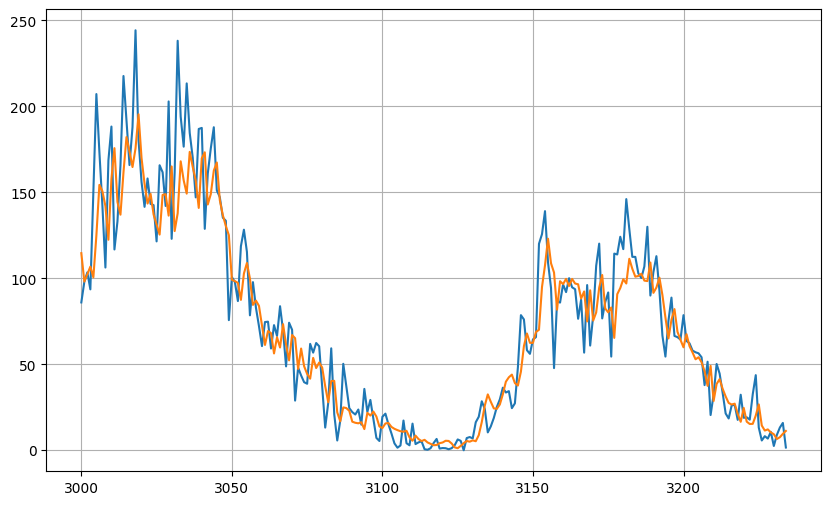

In [17]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [18]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.395303


# Optional

In [19]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=10)

Epoch 1/10
93/93 [==============================] - 5s 10ms/step - loss: 16.7175 - mae: 17.2095
Epoch 2/10
93/93 [==============================] - 1s 10ms/step - loss: 16.7043 - mae: 17.1934
Epoch 3/10
93/93 [==============================] - 1s 10ms/step - loss: 16.6699 - mae: 17.1606
Epoch 4/10
93/93 [==============================] - 1s 10ms/step - loss: 16.6262 - mae: 17.1164
Epoch 5/10
93/93 [==============================] - 1s 10ms/step - loss: 16.6684 - mae: 17.1576
Epoch 6/10
93/93 [==============================] - 1s 9ms/step - loss: 16.6942 - mae: 17.1850
Epoch 7/10
93/93 [==============================] - 1s 10ms/step - loss: 16.6444 - mae: 17.1345
Epoch 8/10
93/93 [==============================] - 1s 10ms/step - loss: 16.6182 - mae: 17.1085
Epoch 9/10
93/93 [==============================] - 1s 10ms/step - loss: 16.6200 - mae: 17.1104
Epoch 10/10
93/93 [==============================] - 2s 15ms/step - loss: 16.6464 - mae: 17.1366


In [20]:
# Set the initial learning rate
initial_learning_rate=1e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=40)

Epoch 1/40
93/93 [==============================] - 5s 10ms/step - loss: 16.6539 - mae: 17.1436
Epoch 2/40
93/93 [==============================] - 1s 11ms/step - loss: 16.6262 - mae: 17.1167
Epoch 3/40
93/93 [==============================] - 1s 10ms/step - loss: 16.6539 - mae: 17.1437
Epoch 4/40
93/93 [==============================] - 1s 10ms/step - loss: 16.6371 - mae: 17.1286
Epoch 5/40
93/93 [==============================] - 1s 10ms/step - loss: 16.6547 - mae: 17.1447
Epoch 6/40
93/93 [==============================] - 1s 10ms/step - loss: 16.7019 - mae: 17.1931
Epoch 7/40
93/93 [==============================] - 2s 16ms/step - loss: 16.6259 - mae: 17.1158
Epoch 8/40
93/93 [==============================] - 1s 10ms/step - loss: 16.6645 - mae: 17.1551
Epoch 9/40
93/93 [==============================] - 1s 9ms/step - loss: 16.6365 - mae: 17.1258
Epoch 10/40
93/93 [==============================] - 1s 9ms/step - loss: 16.5976 - mae: 17.0877
Epoch 11/40
93/93 [======================

8/8 [==============================] - 1s 10ms/step


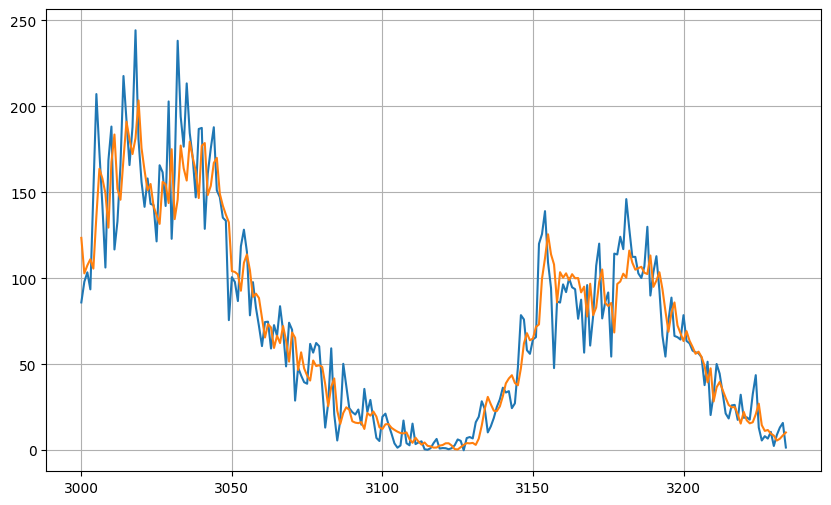

In [21]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [22]:
# Compute the MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.068425